# ExP2のMinistでのベンチマーク

In [1]:
#ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import time
import matplotlib.pyplot as plt

### ExP2 指数擬確率関数の定義

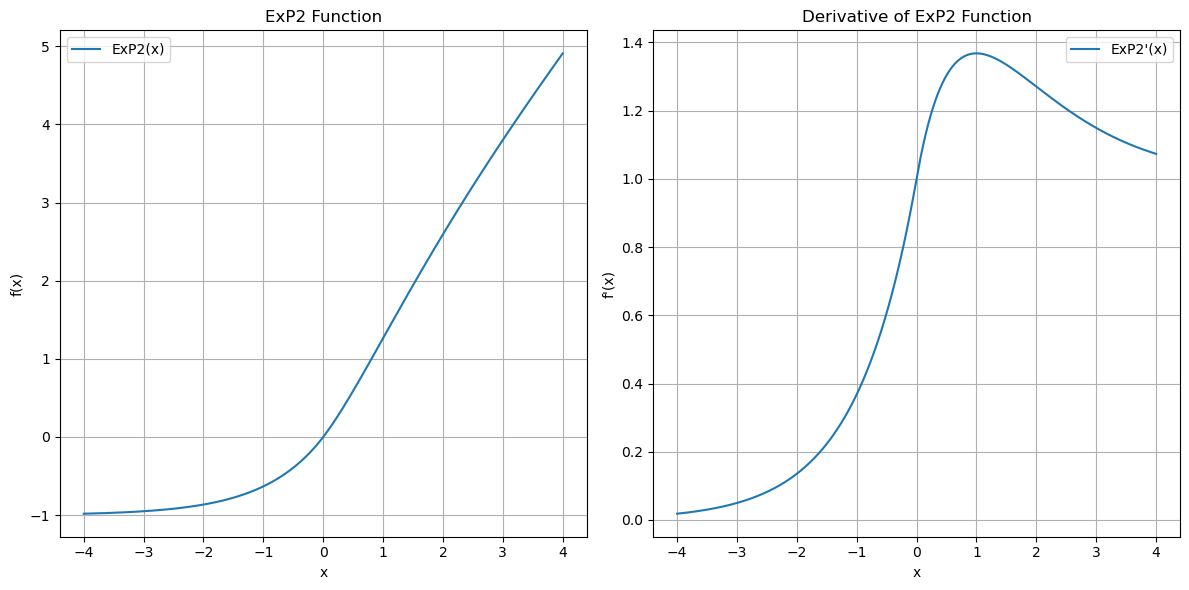

In [2]:
"""

ExP2関数定義

x>=0
 (1-exp(-x))*(1+x)
 
x<0
 -(1-exp(x))


"""
class ExP2(autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # x>=0 (1-exp(-x))*(1+x)
        # x< 0 -(1-exp(x))
        ctx.save_for_backward(x)
        return (torch.sign(x) + torch.relu(x)) * (1 - torch.exp(-torch.abs(x)))

    @staticmethod
    def backward(ctx, grad_output):
        # x>= (x + 1)*exp(-x) + 1 - exp(-x)
        # x>=exp(x)
        x, = ctx.saved_tensors
        s  = torch.sign(x)
        pn = torch.relu(s)
        rx = torch.relu(x)
        ax = torch.abs(x)
        cp = torch.exp(-ax)
        grad_input=((rx+1)*cp+(pn-cp)*pn)*grad_output
        return grad_input
# x の値を -4 から 4 まで生成
x_values = torch.linspace(-4, 4, 400)
x_values.requires_grad = True

# ExP2 関数を適用
y_values = ExP2.apply(x_values)

# 微分を計算
y_values.sum().backward()
dy_values = x_values.grad

# プロット
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_values.detach().numpy(), y_values.detach().numpy(), label="ExP2(x)")
plt.title("ExP2 Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_values.detach().numpy(), dy_values.detach().numpy(), label="ExP2'(x)")
plt.title("Derivative of ExP2 Function")
plt.xlabel("x")
plt.ylabel("f'(x)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("ExP2.png", bbox_inches="tight")
plt.show()

### 勾配消失対策を行わないバージョンの関数※説明用で基本使わない

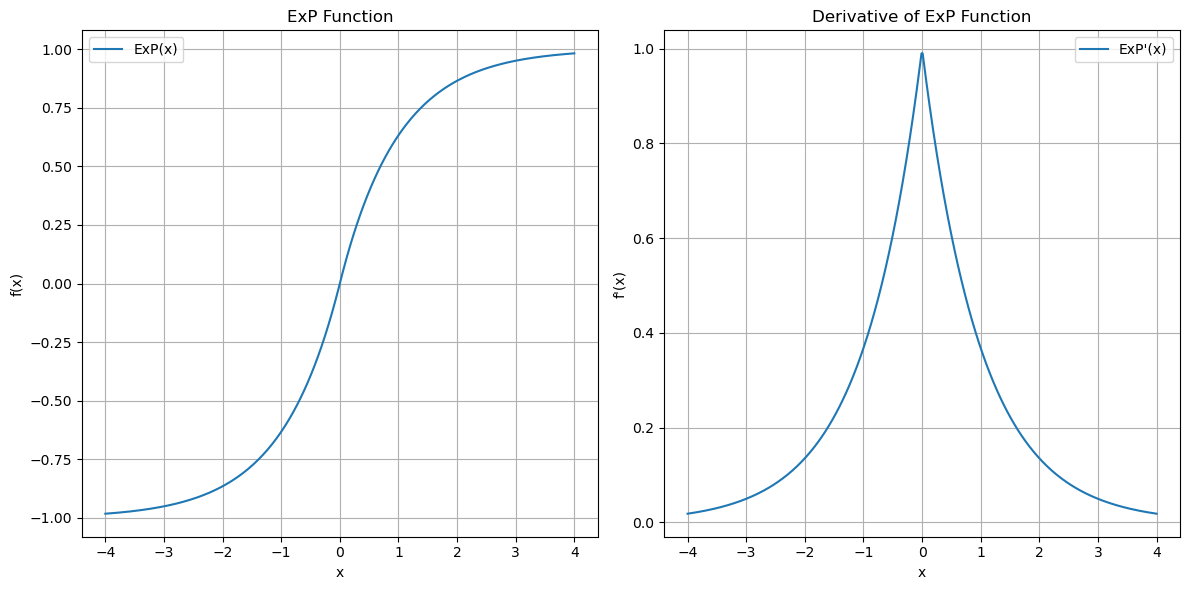

In [3]:
#指数確率関数
class ExP(autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # x>=0 (1-exp(-x))
        # x< 0 -(1-exp(x))
        ctx.save_for_backward(x)
        return (torch.sign(x) *(1 - torch.exp(-torch.abs(x))))

    @staticmethod
    def backward(ctx, grad_output):
        # x>=exp(-x)
        # x>=exp(x)
        x, = ctx.saved_tensors
        s  = torch.sign(x)
        cp = torch.exp(-x*s)
        grad_input=cp*grad_output
        return grad_input
# x の値を -4 から 4 まで生成
x_values = torch.linspace(-4, 4, 400)
x_values.requires_grad = True

# ExP2 関数を適用
y_values = ExP.apply(x_values)

# 微分を計算
y_values.sum().backward()
dy_values = x_values.grad

# プロット
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_values.detach().numpy(), y_values.detach().numpy(), label="ExP(x)")
plt.title("ExP Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_values.detach().numpy(), dy_values.detach().numpy(), label="ExP'(x)")
plt.title("Derivative of ExP Function")
plt.xlabel("x")
plt.ylabel("f'(x)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("ExP.png", bbox_inches="tight")
plt.show()

In [4]:
# GPU利用の設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# データセットの読み込みと前処理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = MNIST(root='./data', train=True, download=True, transform=transform)
test_data = MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

cuda


In [11]:
# 活性化関数の選択
activation_functions = {
    'ExP2_sdg':{
       "function":ExP2.apply,
        "optimizer":"sdg"
    },  
    'GELU_adam':{
       "function":nn.GELU(),
        "optimizer":"adam"
    },
    'ExP2_adam':{
       "function":ExP2.apply,
        "optimizer":"adam"
    },
    'GELU_sdg':{
       "function":nn.GELU(),
        "optimizer":"sdg"
    },
}

ExP2_sdg
Epoch 1/100, Train Loss: 2.3020, Test Accuracy: 11.35%, Test Loss: 2.3020, Epoch Time: 13.57s
Epoch 2/100, Train Loss: 2.3020, Test Accuracy: 10.28%, Test Loss: 2.3024, Epoch Time: 13.64s
Epoch 3/100, Train Loss: 2.3019, Test Accuracy: 11.35%, Test Loss: 2.3013, Epoch Time: 13.66s
Epoch 4/100, Train Loss: 2.3019, Test Accuracy: 11.35%, Test Loss: 2.3017, Epoch Time: 13.92s
Epoch 5/100, Train Loss: 2.3018, Test Accuracy: 11.35%, Test Loss: 2.3017, Epoch Time: 13.83s
Epoch 6/100, Train Loss: 2.3018, Test Accuracy: 11.35%, Test Loss: 2.3012, Epoch Time: 13.68s
Epoch 7/100, Train Loss: 2.3018, Test Accuracy: 10.28%, Test Loss: 2.3015, Epoch Time: 13.74s
Epoch 8/100, Train Loss: 2.3018, Test Accuracy: 11.35%, Test Loss: 2.3012, Epoch Time: 13.64s
Epoch 9/100, Train Loss: 2.3016, Test Accuracy: 11.35%, Test Loss: 2.3016, Epoch Time: 13.72s
Epoch 10/100, Train Loss: 2.3018, Test Accuracy: 11.35%, Test Loss: 2.3011, Epoch Time: 13.95s
Epoch 11/100, Train Loss: 2.3014, Test Accuracy: 1

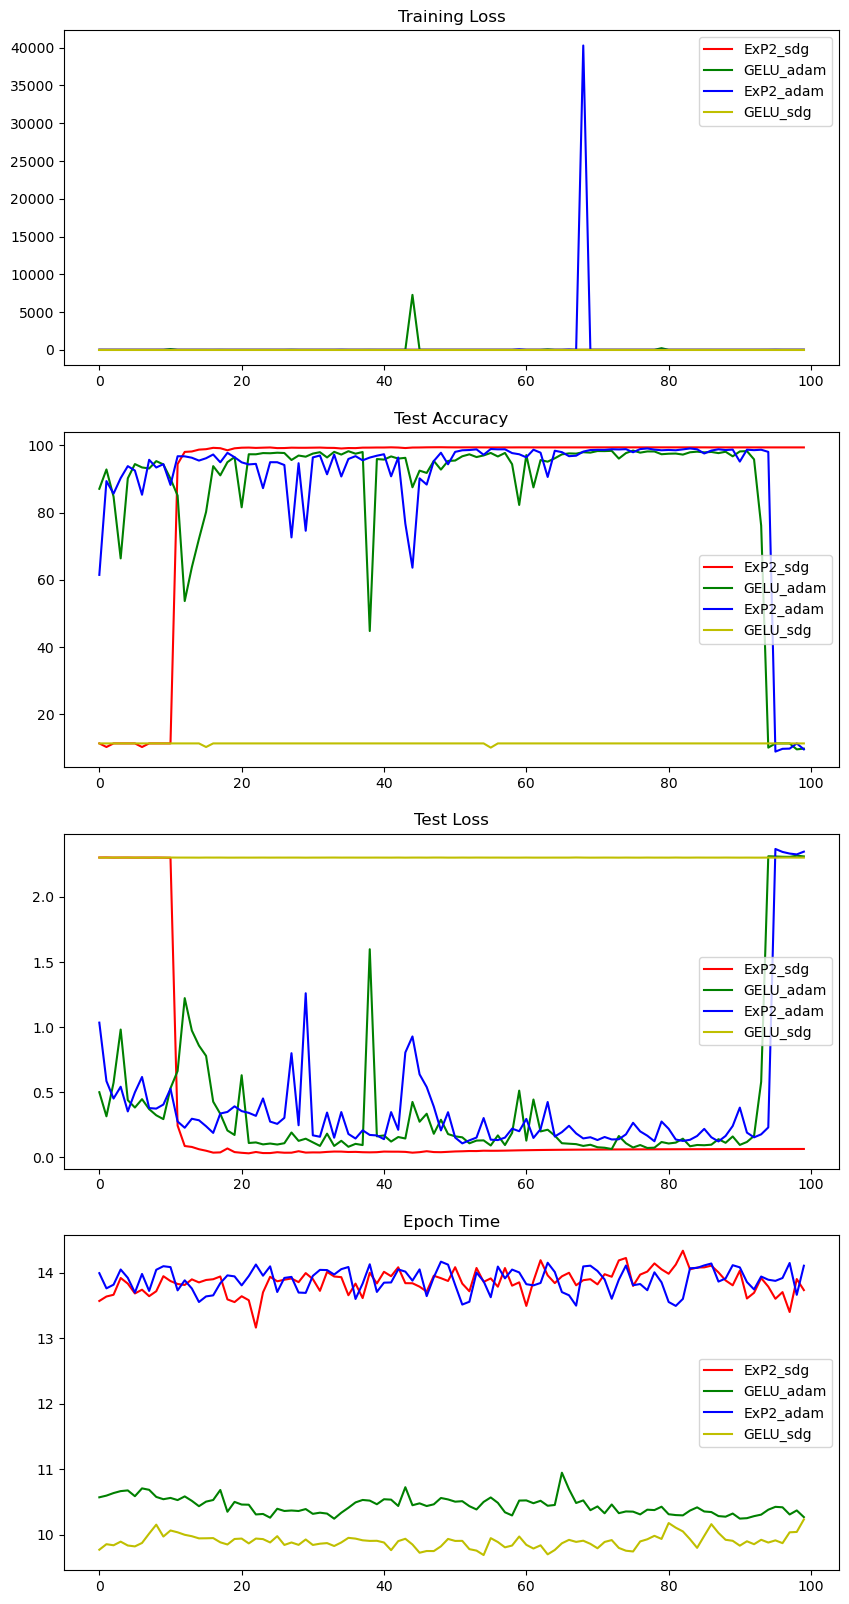

In [12]:
# CNNモデルの定義
class MinstCNN(nn.Module):
    def __init__(self, activation_fn):
        super(MinstCNN,self).__init__()
        #畳み込み層
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        #全結合層 18層
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)

        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 512)
        self.fc6 = nn.Linear(512, 512)

        self.fc7 = nn.Linear(512, 512)
        self.fc8 = nn.Linear(512, 512)
        self.fc9 = nn.Linear(512, 512)
        self.fc10 = nn.Linear(512, 512)

        self.fc11 = nn.Linear(512, 512)
        self.fc12 = nn.Linear(512, 512)
        self.fc13 = nn.Linear(512, 512)
        self.fc14 = nn.Linear(512, 512)

        self.fc15 = nn.Linear(512, 512)
        self.fc16 = nn.Linear(512, 512)
        self.fc17 = nn.Linear(512, 512)
        self.fc18 = nn.Linear(512, 512)
        #出力層
        self.fc19 = nn.Linear(512, 10)
        self.activation = activation_fn
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        
        x= self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))

        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.activation(self.fc6(x))

        x = self.activation(self.fc7(x))
        x = self.activation(self.fc8(x))
        x = self.activation(self.fc9(x))
        x = self.activation(self.fc10(x))

        x = self.activation(self.fc11(x))
        x = self.activation(self.fc12(x))
        x = self.activation(self.fc13(x))
        x = self.activation(self.fc14(x))

        x = self.activation(self.fc15(x))
        x = self.activation(self.fc16(x))
        x = self.activation(self.fc17(x))
        x = self.activation(self.fc18(x))

        x = self.fc19(x)
        return x
    
    
#エポック数の指定
total_epoch=100
# 実験の実行
results = {}
for name, activation in activation_functions.items():
    
    #テストしている関数の表示
    print(name)
    activation_fn=activation["function"]
    
    model = MinstCNN(activation_fn).to(device)
    
    #オプティマイザの選択
    optimizer=None
    if activation["optimizer"]=='adam':
        optimizer = optim.Adam(model.parameters(),lr=0.001)
    if activation["optimizer"]== 'sdg':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    training_losses = []
    test_accuracies = []
    test_losses = []
    times = []

    for epoch in range(total_epoch):
        start_time = time.time()
        model.train()
        training_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        model.eval()
        test_accuracy = 0
        test_loss = 0
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_accuracy = 100 * correct / total
        end_time = time.time()

        training_losses.append(training_loss / len(train_loader))
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss / len(test_loader))
        times.append(end_time - start_time)

        print(f'Epoch {epoch+1}/{total_epoch}, Train Loss: {training_loss / len(train_loader):.4f}, '
              f'Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss / len(test_loader):.4f}, '
              f'Epoch Time: {end_time - start_time:.2f}s')

    results[name] = (training_losses, test_accuracies, test_losses, times)

# 結果のグラフ化
colors = ['r', 'g', 'b', 'y', 'm']
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
for i, (name, (training_losses, test_accuracies, test_losses, times)) in enumerate(results.items()):
    ax[0].plot(training_losses, label=name, color=colors[i])
    ax[1].plot(test_accuracies, label=name, color=colors[i])
    ax[2].plot(test_losses, label=name, color=colors[i])
    ax[3].plot(times, label=name, color=colors[i])

ax[0].set_title('Training Loss')
ax[1].set_title('Test Accuracy')
ax[2].set_title('Test Loss')
ax[3].set_title('Epoch Time')
for axes in ax:
    axes.legend()

plt.savefig("minst_exp2_test.png", bbox_inches="tight")
plt.show()

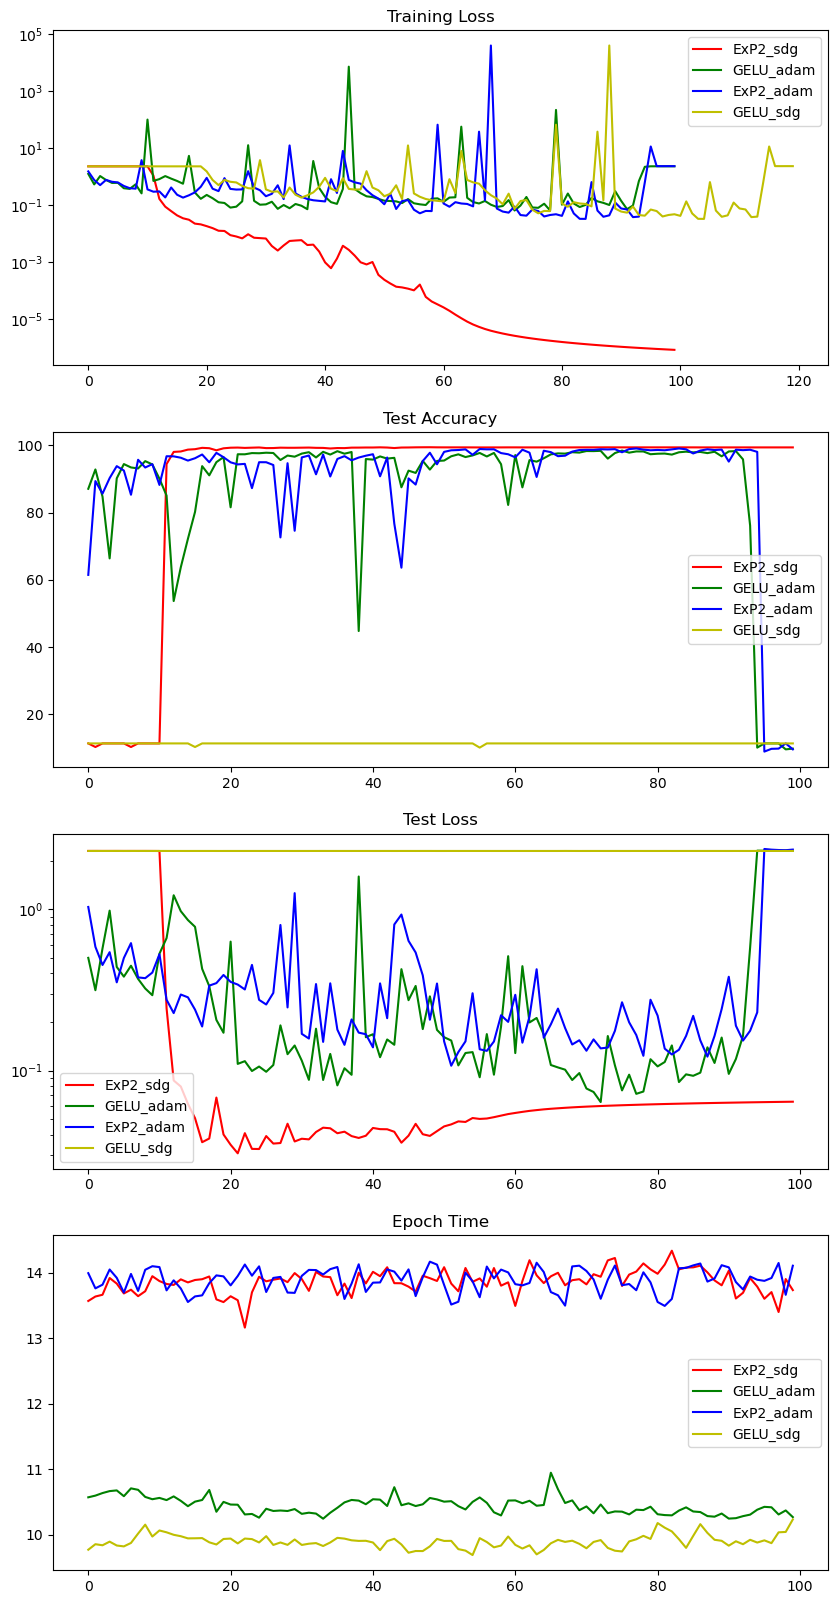

In [113]:
# 結果のグラフ化
colors = ['r', 'g', 'b', 'y', 'm']
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
for i, (name, (training_losses, test_accuracies, test_losses, times)) in enumerate(results.items()):
    ax[0].plot(training_losses, label=name, color=colors[i])
    ax[1].plot(test_accuracies, label=name, color=colors[i])
    ax[2].plot(test_losses, label=name, color=colors[i])
    ax[3].plot(times, label=name, color=colors[i])

    
ax[0].set_yscale('log')
ax[1]
ax[2].set_yscale('log')
    
ax[0].set_title('Training Loss')
ax[1].set_title('Test Accuracy')
ax[2].set_title('Test Loss')
ax[3].set_title('Epoch Time')
for axes in ax:
    axes.legend()

plt.savefig("minst_exp2_test.png", bbox_inches="tight")
plt.show()

In [52]:
import pandas as pd

In [107]:
dfs=[]
for k in results.keys():
    df_af=pd.DataFrame(results[k]).T
    df_af.columns=['training_losses','test_accuracies','test_losses','times']
    df_af['epoch']=[i for i in range(df_af.shape[0])]
    df_af['activation_function']=k
    dfs.append(df_af)

In [108]:
result_df=pd.concat(dfs)[['activation_function','training_losses','test_accuracies','test_losses','times','epoch']]

In [109]:
top_score=[]
for i,df in result_df.groupby('activation_function'):
    max_test_accuracy=max(df['test_accuracies'])
    max_test_accuracy_times=df[df['test_accuracies']== max_test_accuracy][:1]
    top_score.append(max_test_accuracy_times)

In [111]:
pd.concat(top_score)

,activation_function,training_losses,test_accuracies,test_losses,times,epoch
77,ExP2_adam,0.039981,99.07,0.166015,13.732322,77
48,ExP2_sdg,0.001009,99.43,0.039284,13.916070,48
75,GELU_adam,0.082982,98.44,0.075263,10.352127,75
0,GELU_sdg,2.301753,11.35,2.301202,9.770774,0


In [112]:
result_df.to_csv('exp2_test_score.csv')